In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats.stats import pearsonr
import scipy.optimize as optimize
import math
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import neighbors
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score, median_absolute_error

df_tran = pd.read_csv('./dataset/tran.txt',names=['primary-date','time','approximate-indicator','secondary-date','approximate-indicator',
  'transaction-ID','player','type','from-team','from-league','to-team','to-league','draft-type','draft-round','pick-number','info'])
df_playerid = pd.read_csv('./dataset/playerid_list.csv',names=['LASTNAME','FIRSTNAME','PLAYERID','DAVENPORTCODE','MLBCODE','player'],skiprows=1);
df_master = pd.read_csv('./dataset/Master.csv')
df_batting = pd.read_csv('./dataset/Batting.csv')
df_pitching = pd.read_csv('./dataset/Pitching.csv')
df_fielding = pd.read_csv('./dataset/Fielding.csv')
df_batstat = pd.read_csv('./dataset/war_daily_bat.txt')
df_pitchstat = pd.read_csv('./dataset/war_daily_pitch.txt')
df_cpi = pd.read_csv('./dataset/CPI.csv')
df_salaries = pd.read_csv('./dataset/Salaries.csv')
pd.set_option('display.max_columns', 60)
df_teams = pd.read_csv('./dataset/Teams.csv')
df_allstars = pd.read_csv('./dataset/AllstarFull.csv')

# Data Cleanup
# Recontructing invalid dates
df_tran['primary-date'] = df_tran['primary-date'].astype('str')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})[0]{4}', r'\g<1>0101')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})(..)[0]{2}', r'\g<1>\g<2>01')

#Extracting only trades from transaction dataframe
df_tran = df_tran[df_tran['type'] == "T "]
df_tran = df_tran[df_tran['to-league'].isin(['AL','NL'])]
df_tran = df_tran[df_tran['from-league'].isin(['AL','NL'])]

df_tran['primary-date'] = pd.to_datetime(df_tran['primary-date'], format='%Y%m%d')
df_tran['tranYear'] = df_tran['primary-date'].apply(lambda x : int(x.year))

#Cleaning cash transactions
dcash = df_tran['info'].str.replace(r' million', '000000') #replace million
dcash = dcash.str.replace(r'\D*\d*(\$\d*)\D*\d*', '\g<1>') #strip anything but $ followed by some digits
dcash = dcash.str.replace(r'\$$', '$0') #replace unknown cash as 0
df_tran['cash'] = dcash.str.replace(r'^((?!\$\d*).)*$', '') #replace anything that doen't contain a dollar with empty string

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
df_master['player_ID'] = df_master['bbrefID']
df_batstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')
df_pitchstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')
df_batting = pd.merge(df_batting,df_master[['playerID','retroID','birthYear']],on='playerID')
df_pitching = pd.merge(df_pitching,df_master[['playerID','retroID','birthYear']],on='playerID')
df_fielding = pd.merge(df_fielding,df_master[['playerID','retroID','birthYear']],on='playerID')
df_batting['age']= df_batting['yearID'] - df_batting['birthYear']
df_pitching['age']= df_pitching['yearID'] - df_pitching['birthYear']
df_fielding['age']= df_fielding['yearID'] - df_fielding['birthYear']
df_allstars = pd.merge(df_allstars,df_master[['playerID','retroID']], on='playerID',how='inner')

Advanced Model

In [3]:
# Find average player performance
df_batstat_sort = df_batstat.sort('age')
df_batstat_sort = df_batstat_sort[pd.notnull(df_batstat_sort['age'])]
agedict = {}

for index, row in df_batstat_sort.iterrows():
    if(row['age'] in agedict):
        agedict[row['age']].append(row['WAR'])
    else:
        agedict[row['age']] = [row['WAR']]
        
age = []
avg_WAR= []
i=0
for key in agedict:
    if (~np.isnan(key)):
        avg = np.nansum(agedict[key]) / float(len(agedict[key]))
        age.append(key)
        avg_WAR.append(avg)
        
age_df = pd.DataFrame({ 'Age' : age,'Average_WAR' : avg_WAR}).sort('Age')

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:21: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [4]:
# Helper function which returns the average WAR value given an age
def getAvgWarForAge(age):
    return (age_df[(age_df['Age'] == age)]['Average_WAR']).iloc[0]

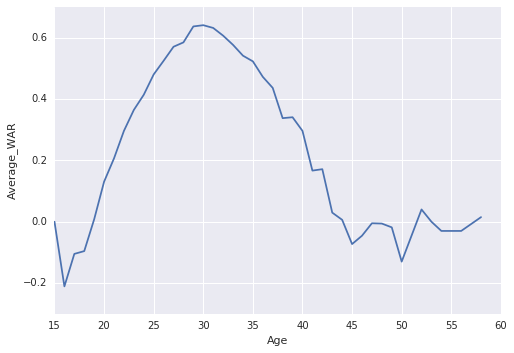

In [5]:
plt.xlabel("Age")
plt.ylabel("Average_WAR")
plt.plot(age_df.Age, age_df.Average_WAR);

In [7]:
# Find Salary Eqivalent of WAR
import re
#Taking 2016 CPI as current
curr_cpi = df_cpi[df_cpi['Year']==2016]['CPI'].iloc[0]

#Calculating the value of each cash tran as per CPI to 2016 value
#When incorrect values obeserved, making the new val as -1
new_cash_val = []
for index, row in df_tran.iterrows():
    if not((pd.isnull(row['cash'])) ):
        t1 = row['cash']
        t1 = re.sub('[$]', '', t1)
        old_cpi_df = df_cpi[df_cpi['Year']== row['tranYear']]['CPI']
        old_cpi = old_cpi_df.iloc[0]
        #print t1,old_cpi
        try:
            new_val = float((curr_cpi/old_cpi))*float(t1)
            #print new_val
            new_cash_val.append(new_val)
        except ValueError as e:
            new_cash_val.append(-1)
    else:
        new_cash_val.append(-1)

#Finally adding the calculated values as a new column in df_tran without the $ sign
df_tran['cash_curr'] = new_cash_val

In [8]:
cash_list = []
for index,row in df_tran.iterrows():
        if(row['cash_curr'] > 0):
            cash_list.append(row['cash_curr'])
cash_list.sort()
rep_cash = sum(cash_list[:50])/50
df_tran['cash_curr'] = df_tran['cash_curr'].apply(lambda x : rep_cash if x == 0 else x)

In [9]:
df_salaries = pd.read_csv('./dataset/Salaries.csv')
#adjusting salaries based  on inflation
curr_cpi = df_cpi[df_cpi['Year']==2016]['CPI'].iloc[0]
#Calculating the value of each sallaries as per CPI to 2016 value
salary_per_yr = []
war=[]
for index, row in df_salaries.iterrows():
    if not((pd.isnull(row['salary'])) ):
        t1 = row['salary']
        old_cpi_df = df_cpi[df_cpi['Year']== row['yearID']]['CPI']
        player_war = df_batstat[(df_batstat['year_ID']==row['yearID']) & (df_batstat['player_ID']==row['playerID'])]['WAR']
        if (player_war.empty):
            player_war = df_pitchstat[(df_pitchstat['year_ID']==row['yearID']) & (df_pitchstat['player_ID']==row['playerID'])]['WAR']
        if (player_war.empty):
            war.append(0)
        else:
            war.append(player_war.values[0])
        old_cpi = old_cpi_df.iloc[0]
        try:
            new_val = float((curr_cpi/old_cpi))*float(t1)
            salary_per_yr.append(new_val)
        except ValueError as e:
            salary_per_yr.append(0)
    else:
        war.append(0)
        salary_per_yr.append(0)

In [10]:
df_salaries['Salary_curr'] = salary_per_yr
df_salaries['WAR'] = war
average_salary = np.nansum(salary_per_yr) / float(len(salary_per_yr))
average_war = np.nansum(war) / float(len(war))
print(average_salary, average_war)

2514082.95989 0.639999608993


In [11]:
c2War =  average_war / average_salary 

In [12]:
# Project WAR values based on average of past performance of a player
def player_performance_projection(playerID, age):
    player_df = df_batstat[(df_batstat['retroID'] == playerID)]
    player_df_before = player_df[player_df['age']< age]
    diff = [0]
    for index,row in player_df_before.iterrows():
        diff.append(row['WAR'] - getAvgWarForAge(row['age']))
    mPerf  = np.mean(diff)    
    dict = {}
    for j in range(1,16):
        if age + j < 50:
            dict[j] = (getAvgWarForAge(age + j) + mPerf/j)
        else:
            dict[j] = 0
    return dict

In [13]:
# Projected trade value using the player performance projection
def trade_value_year_projection(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        valDict = {}
        for index, row in td.iterrows():
            val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction
                    if(row['cash_curr'] > 0):
                        wVal =  row['cash_curr'] * c2War / 5
                        for l in range(0,5):
                            if l in valDict.keys():
                                valDict[l] += wVal
                            else:
                                valDict[l] = wVal
                    continue
                birthYear = df_master['birthYear'][df_master['retroID'] == row['player']]
                if birthYear.empty:
                    continue
                birthYear = birthYear.iloc[0]
                age = row['tranYear'] - birthYear
                tempDict = player_performance_projection(row['player'],age)
                for i in range(1,16):
                    if i in valDict.keys():
                        valDict[i] += tempDict[i]
                    else:
                        valDict[i] = tempDict[i]
        player_vals.append(valDict)
    return player_vals

In [14]:
# optimization function modelled similar to Amount in Compount Interest
def f(c):
    ret = 0.0
    for key, value in dict1.items():
        ret  += pow((1 - c[0]/100),key)*value
    for key, value in dict2.items():
        ret  -= pow((1 - c[1]/100),key)*value
    return abs(ret)

bnds = ((0, 100), (0, 100))

In [15]:
# Using TNC Optimization to find rates such that the trade value at time of trade are equal
trade_val_projection_list = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    listnew = trade_value_year_projection(x,'WAR')
    dict1 = listnew[0]
    dict2 = listnew[1]
    result = optimize.minimize(f, (50, 50), method='TNC', bounds=bnds)
    trade_val_projection_list.append((x,result.x,result.fun))

In [16]:
import pickle
with open('trade_val_projection.pkl', 'wb') as f:
    pickle.dump(trade_val_projection_list,f)

In [17]:
# Extracts the actual WAR metric for each year following the trade for both teams
def trade_value_year_actual(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        valDict = {}
        for index, row in td.iterrows():
            val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction
                    continue
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(player_df['year_ID'] == row['tranYear'])]
                #instead need a df for the player after the trans year, and not just next, but all consecutive years
                for i in range(1,15):
                    player_df_year_next = player_df[(player_df['year_ID'] == (row['tranYear'] + i))]
                    if not player_df_year_next.empty:
                        # get the value of metric for each year after trade until 15 years else assume 0
                        t = float(player_df_year_next[metric].iloc[0])
                        #print(t)
                        if i in valDict.keys():
                            valDict[i] += t
                        else:
                            valDict[i] = t
                    else:
                        ## figure out a way to find war for these players
                        if i in valDict.keys():
                            valDict[i] += 0
                        else:
                            valDict[i] = 0
        player_vals.append(valDict)
    return player_vals

In [19]:
# Compute trade value using same decay rate but with actual WAR values 
def f2(c,dict_1,dict_2):
    ret = 0.0
    for key, value in dict_1.items():
        ret  += pow((1 - c[0]/100),key)*value
    for key, value in dict_2.items():
        ret  -= pow((1 - c[1]/100),key)*value
    return ret

diff_list = [] 
for i in trade_val_projection_list:
    listnew = trade_value_year_actual(i[0],'WAR') #should come from projections instead of actual value
    act = f2( i[1], listnew[0], listnew[1])
    diff_list.append((i[0],abs(act),act))

In [20]:
import pickle
with open('diff_list.pkl', 'wb') as f:
    pickle.dump(diff_list,f)

In [3]:
import pickle
with open("diff_list.pkl", "rb") as input_file:
    diff_list = pickle.load(input_file)

In [21]:
# Sort based on trade value diff
sList = sorted(diff_list,key=lambda x: x[1], reverse=True)

In [298]:
# Pretty print
rank_df = pd.DataFrame(columns = ['Rank','Date','Team1','Team2','Players Team1','Player Team2','Trade Value Diff','Absolute Trade Value Diff'])
k = 0
for i in sList:
    tranID = i[0]
    tran = df_tran[df_tran['transaction-ID'] == tranID]
    teams = tran['from-team'].unique()
    t1 = teams[0]
    t2 = teams[1]
    p1List = []
    p2List = []
    for index,row in tran.iterrows():
        pl = df_master[df_master['retroID'] == row['player']]
        if row['from-team'] == t1:
            p1List.append(''.join(pl['nameFirst'].values +" "+ pl['nameLast'].values))
        else:
            p2List.append(''.join(pl['nameFirst'].values + " " + pl['nameLast'].values))
    p1str = ','.join(p1List)
    p2str = ','.join(p2List)
    date = tran['primary-date'].iloc[0]
    rank_df.loc[k] = [int(k+1),date,t1,t2,p1str,p2str,i[2],i[1]]
    k += 1

In [20]:
# Top 10 worst trade as per advanced analysis
rank_df.head(10)

,Rank,Date,Team1,Team2,Players Team1,Player Team2,Trade Value Diff
0,1.0,1949-12-14,NY1,BSN,"Sid Gordon,Buddy Kerr,Willard Marshall,Red Webb","Eddie Stanky,Al Dark",8.103336
1,2.0,1959-12-06,CLE,CHA,"Minnie Minoso,Dick Brown,Don Ferrarese,Jake St...","John Romano,Bubba Phillips,Norm Cash",7.831614
2,3.0,1963-01-14,BAL,CHA,"Hoyt Wilhelm,Dave Nicholson,Pete Ward,Ron Hansen","Luis Aparicio,Al Smith",7.402284
3,4.0,1959-12-11,NYA,KC1,"Don Larsen,Hank Bauer,Norm Siebern,Marv Throne...","Roger Maris,Joe DeMaestri,Kent Hadley",7.368413
4,5.0,1946-09-30,PIT,BSN,"Bob Elliott,Hank Camelli","Billy Herman,Elmer Singleton,Stan Wentzel,Whit...",7.213203
5,6.0,1999-12-22,SDN,ATL,"Wally Joyner,Reggie Sanders,Quilvio Veras","Bret Boone,Ryan Klesko,Jason Shiell",7.159809
6,7.0,1904-12-26,BOS,SLA,",George Stone",Jesse Burkett,7.089060
7,8.0,1928-10-29,NY1,PHI,",Lefty O'Doul",Freddy Leach,6.958705
8,9.0,1997-11-18,TBA,PHI,Bobby Abreu,Kevin Stocker,6.815524
9,10.0,1928-11-07,CHN,BSN,",Socks Seibold,Percy Jones,Lou Legett,Freddie ...",Rogers Hornsby,6.784525


In [299]:
rank_df.to_csv("Analysed_Ranks_2.csv")

# Prediction

Feature Extraction

In [29]:
# Calculate no. of past trades in a year
curr_cpi = df_cpi[df_cpi['Year']==2016]['CPI'].iloc[0]
df_sort = df_tran.sort(['transaction-ID'])
no_of_trade = pd.DataFrame(columns = ['Year','PIT', 'SL5', 'CHN', 'WS8', 'IN3', 'PHI', 'NY1', 'LS3', 'SLN',
       'BLN', 'BSN', 'BRO', 'WSN', 'CL4', 'CIN', 'CLE', 'BOS', 'DET',
       'WS1', 'CHA', 'NYA', 'SLA', 'PHA', 'MLN', 'BAL', 'KC1', 'SFN',
       'LAN', 'WS2', 'LAA', 'MIN', 'HOU', 'NYN', 'CAL', 'ATL', 'OAK',
       'SDN', 'KCA', 'MON', 'SE1', 'MIL', 'TEX', 'TOR', 'SEA', 'FLO',
       'COL', 'ANA', 'ARI', 'TBA', 'WAS', 'MIA'] )
#no_of_trade = no_of_trade.set_index(['Year'])
#no_of_trade=no_of_trade.fillna(0.0, inplace=True)
td = df_sort['transaction-ID'].unique()
year = df_sort['tranYear'].unique()
no_of_trade['Year'] = year
no_of_trade=no_of_trade.fillna(0)
for x in range(0, len(td)):
    tran_id = df_sort[df_sort['transaction-ID']==td[x]].iloc[0]
    yr = no_of_trade[no_of_trade['Year'] == tran_id['tranYear']].iloc[0]
    yr[tran_id['from-team']] = yr[tran_id['from-team']] + 1;
    no_of_trade[tran_id['from-team']][no_of_trade['Year'] == tran_id['tranYear']] = yr[tran_id['from-team']]
    yr[tran_id['to-team']] = yr[tran_id['to-team']] + 1;
    no_of_trade[tran_id['to-team']][no_of_trade['Year'] == tran_id['tranYear']] = yr[tran_id['to-team']]
    
tdiffDict = {}
for i in sList:
    tdiffDict[i[0]] = i[2]

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [82]:
# Assign a score to each Manager
df_manager = pd.read_csv('./dataset/Managers.csv')
df_manager= df_manager.sort( ['playerID','yearID'] )
playerID= ''
yearID= ''
win = 0
loss= 0
Game= 0
for i, row in df_manager.iterrows():
    if playerID == row['playerID']:
        loss = row['L'] + loss
        win = row['W'] + win
        Game = row['G'] + Game
        df_manager['W'][i] = win;
        df_manager['L'][i] = loss;
        df_manager['G'][i] = Game;
        
    else:
        playerID= row['playerID']
        yearID= row['yearID']
        win = row['W']
        loss = row['L']
        Game = row['G']

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

In [83]:
#Calculates various params for each trade
def trade_value_old(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    year = td['tranYear'].iloc[0]
    player_vals = [] #To calculate player val diff
    num_players = [] #To calculate diff of number of players involved
    num_trades = [] #To calculate number of trades each side players were involved in before the trade
    num_trades_team = [] #To calculate number of trades each team did in this year
    ages = [] #Average ages of the two sides
    ranks = []
    salary_vals = []
    allstar_vals = []
    num_pitchers = []
    num_batters = []
    for x in teams:
        #print x
        val = 0 #for player_vals[]
        num = 0 #for num_players[]
        age = 0 #for ages[]
        num_tr = 0 # for num_trades[]
        sal = 0
        num_p = 0
        num_b = 0
        t_ranks = df_teams[(df_teams['teamIDretro'] == x)]
        t_rank = t_ranks[(t_ranks['yearID'] == year)]
        if not t_rank.empty:
            rank = t_rank['Rank'].iloc[0]
        else:
            rank = 7
            
        num_tr_team = no_of_trade[x][no_of_trade['Year']==year].iloc[0]
        num_awards = 0
        
        for index, row in td.iterrows():
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction 
                    continue
                num += 1
                #year = int(row['tranYear'])
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(df_batstat['year_ID'] == row['tranYear'])]
                
                trades = df_tran[(df_tran['player'] == row['player'])]
                trades_before = trades[(trades['tranYear'] < row['tranYear'])]
                num_tr += len(trades_before)
                
                awards_before = df_allstars[df_allstars['yearID'] < row['tranYear']]
                awards_player = awards_before[awards_before['retroID'] == row['player']]
                num_awards += len(awards_player)
                
                if not player_df_year.empty:
                    val += float(player_df_year[metric].iloc[0])
                    age += player_df_year['age'].iloc[0]
                    slp = player_df_year['salary'].iloc[0]
                    if not math.isnan(slp):
                        sal += slp
                    if(player_df['pitcher'].iloc[0] == 'Y'):
                        num_p += 1
                    else:
                        num_b += 1
                elif not player_df.empty:
                    # take a random value if we don't have war for that transaction year
                    val += float(player_df[metric].iloc[0])
                    age += player_df['age'].iloc[0]
                    slp = float(player_df['salary'].iloc[0])
                    if not math.isnan(slp):
                        sal += slp
                    if(player_df['pitcher'].iloc[0] == 'Y'):
                        num_p += 1
                    else:
                        num_b += 1
                else:
                    ## figure out a way to find war for these players
                    val += 0
        num_players.append(num)
        num_trades.append(num_tr)
        num_trades_team.append(num_tr_team)
        player_vals.append(val)
        ranks.append(rank)
        salary_vals.append(sal)
        allstar_vals.append(num_awards)
        num_pitchers.append(num_p)
        num_batters.append(num_b)
        if(num==0):
            num = 1
        ages.append(float(age/num))
        v_diff = tdiffDict[tranID]
    sal_diff = abs(salary_vals[0]-salary_vals[1])
    new_val = sal_diff
    old_cpi_df = df_cpi[df_cpi['Year']== year]['CPI']
    old_cpi = old_cpi_df.iloc[0]
    try:
        new_sal_diff = int(float((curr_cpi/old_cpi))*float(sal_diff))
    except ValueError as e:
        new_sal_diff = sal_diff
    #return (abs(player_vals[0]-player_vals[1]),tranID,abs(num_players[0]-num_players[1]),year,abs(ages[0]-ages[1]),v_diff)
    resultDict = {}
    resultDict['TranID'] = tranID
    resultDict['Year'] = year
    resultDict['Team_1'] = teams[0]
    resultDict['Team_2'] = teams[1]
    resultDict['Trade_Value_Diff'] = v_diff
    resultDict['WAR_Sum_1'] =  player_vals[0]
    resultDict['WAR_Sum_2'] = player_vals[1]
    resultDict['Num_Players_1'] = num_players[0]
    resultDict['Num_Players_2'] = num_players[1]
    resultDict['Ages_1'] = ages[0]
    resultDict['Ages_2'] = ages[1]
    resultDict['Num_Player_Trades_1'] = num_trades[0]
    resultDict['Num_Player_Trades_2'] = num_trades[1]
    resultDict['Rank_1'] = ranks[0]
    resultDict['Rank_2'] = ranks[1]
    resultDict['Num_Trades_Team_1'] = num_trades_team[0]
    resultDict['Num_Trades_Team_2'] = num_trades_team[1]
    resultDict['Salary_Diff'] = new_sal_diff
    resultDict['allstar_1'] = allstar_vals[0]
    resultDict['allstar_2'] = allstar_vals[1]
    resultDict['Num_Pitchers_1'] = num_pitchers[0]
    resultDict['Num_Pitchers_2'] = num_pitchers[1]
    resultDict['Num_Batters_1'] = num_batters[0]
    resultDict['Num_Batters_2'] = num_batters[1]
    mgr_table1 = df_manager[df_manager['yearID'] == year]
    mgr_table = mgr_table1[mgr_table1['teamID'] == teams[0]]
    if mgr_table.empty:
        resultDict['Manager1_Score'] =  0.5
    else:
        resultDict['Manager1_Score'] =  (float)(mgr_table['W'].iloc[0]/(float)(mgr_table['G'].iloc[0]))
    mgr_table = mgr_table1[mgr_table1['teamID'] == teams[1]]
    if mgr_table.empty:
        resultDict['Manager2_Score'] =   0.5
    else:
        resultDict['Manager2_Score'] =  (float)(mgr_table['W'].iloc[0]/(float)(mgr_table['G'].iloc[0]))
    return resultDict

In [84]:
trade_val_list_WAR_old = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    trade_val_list_WAR_old.append(trade_value_old(x,'WAR'))

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [85]:
df_features = pd.DataFrame(trade_val_list_WAR_old, columns=["TranID","Year","Team_1","Team_2","Trade_Value_Diff","WAR_Sum_1",
                                                            "WAR_Sum_2","Num_Players_1","Num_Players_2","Ages_1","Ages_2",
                                                            "Num_Player_Trades_1","Num_Player_Trades_2","Rank_1","Rank_2","Num_Trades_Team_1",
                                                            "Num_Trades_Team_2","Salary_Diff","allstar_1","allstar_2","Num_Pitchers_1",
                                                            "Num_Pitchers_2","Num_Batters_1","Num_Batters_2","Manager1_Score","Manager2_Score"])

In [89]:
#To add average val of trades carried out earlier by each team
avg_lop = 0
for index,row in df_features.iterrows():
    trades = df_features[(df_features['Team_1'] == row['Team_1'])]
    trades_before = trades[(trades['Year'] < row['Year'])]
    if len(trades_before) == 0:
        avg_lop = 0
    else:
        avg_lop = sum(trades_before['Trade_Value_Diff'])/len(trades_before)
    df_features.set_value(index,'Avg_Lops_1',avg_lop)
    
    trades = df_features[(df_features['Team_2'] == row['Team_2'])]
    trades_before = trades[(trades['Year'] < row['Year'])]
    if len(trades_before) == 0:
        avg_lop = 0
    else:
        avg_lop = sum(trades_before['Trade_Value_Diff'])/len(trades_before)
    df_features.set_value(index,'Avg_Lops_2',avg_lop)

In [90]:
import pickle
with open('features.pkl', 'wb') as f:
    pickle.dump(df_features,f)

In [357]:
import pickle
with open('features.pkl', 'rb') as f:
    df_features = pickle.load(f)

In [366]:
df_features['Num_Player_Diff'] = abs(df_features['Num_Players_1'] - df_features['Num_Players_2'])
df_features['Age_Diff'] = abs(df_features['Ages_1'] - df_features['Ages_2'])
df_features['WAR_Diff'] = abs(df_features['WAR_Sum_1'] - df_features['WAR_Sum_2'])
df_features['Num_Trades_Diff'] = abs(df_features['Num_Player_Trades_1'] - df_features['Num_Player_Trades_2'])
df_features['AllStar_Diff'] = df_features['allstar_1'] - df_features['allstar_2']
df_features['Abs_Trade_Value_Diff'] = abs(df_features['Trade_Value_Diff'])
df_features['Manager_Diff'] = abs(df_features['Manager1_Score'] - df_features['Manager2_Score'])
df_features['Avg_Lopsided_Diff'] = abs(df_features['Avg_Lops_1'] - df_features['Avg_Lops_2'])
df_features['Pitcher_Diff'] = abs(df_features['Num_Pitchers_1'] - df_features['Num_Pitchers_2'])
df_features['Batters_Diff'] = abs(df_features['Num_Batters_1'] - df_features['Num_Batters_2'])

Feature Selction

In [528]:
df_selection = pd.DataFrame()
df_selection['Num_Player_Diff'] = abs(df_features['Num_Players_1'] - df_features['Num_Players_2'])
df_selection['Age_Diff'] = abs(df_features['Ages_1'] - df_features['Ages_2'])
df_selection['WAR_Diff'] = abs(df_features['WAR_Sum_1'] - df_features['WAR_Sum_2'])
df_selection['Num_Trades_Diff'] = abs(df_features['Num_Player_Trades_1'] - df_features['Num_Player_Trades_2'])
df_selection['AllStar_Diff'] = df_features['allstar_1'] - df_features['allstar_2']
df_selection['Abs_Trade_Value_Diff'] = abs(df_features['Trade_Value_Diff'])
df_selection['Manager_Score_Diff'] = abs(df_features['Manager1_Score'] - df_features['Manager2_Score'])
df_selection['Avg_Lopsided_Diff'] = abs(df_features['Avg_Lops_1'] - df_features['Avg_Lops_2'])
df_selection['Pitcher_Diff'] = abs(df_features['Num_Pitchers_1'] - df_features['Num_Pitchers_2'])
df_selection['Batters_Diff'] = abs(df_features['Num_Batters_1'] - df_features['Num_Batters_2'])
df_selection['Salary_Diff'] = abs(df_features['Salary_Diff'])
df_selection['Num_Player_Trades_Diff'] = abs(df_features['Num_Player_Trades_2'] - df_features['Num_Player_Trades_1'] ) 

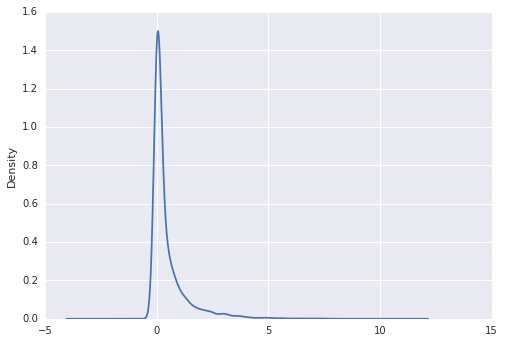

In [33]:
ser = df_features['Abs_Trade_Value_Diff']
ser.plot.kde()

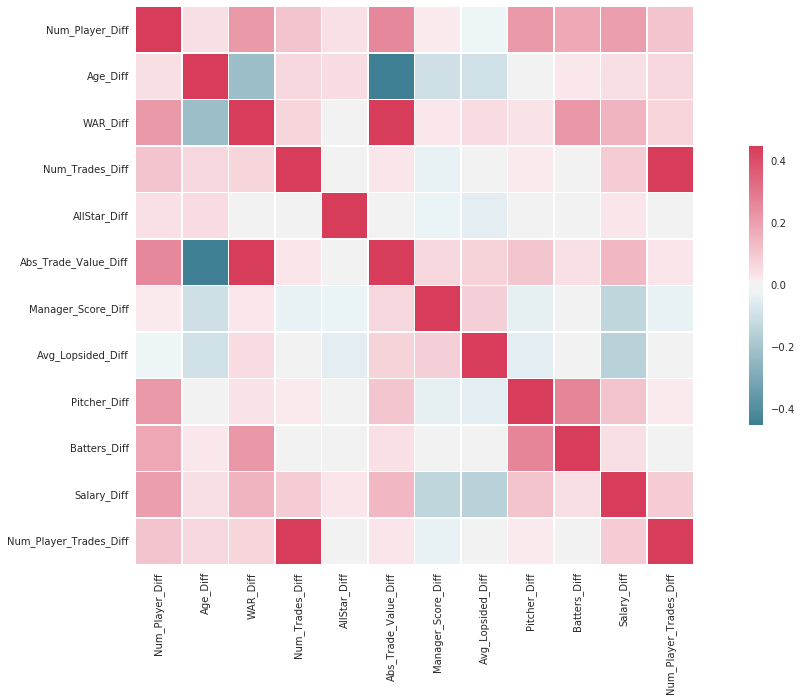

In [529]:
cols = df_selection.columns
correlations = df_selection[cols].corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 5, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, cmap=cmap, vmax=.3,
            square=True, xticklabels=correlations.columns, yticklabels=correlations.columns,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Regression

In [374]:
#Shuffling the data set and filtering out 2015 tranactions
df_features = df_features.sample(frac=1)
df_features_new = df_features[df_features['Year'] < 2015]

In [375]:
# Input features for the model
inputV = df_features_new[["WAR_Sum_1", "WAR_Sum_2","Num_Players_1","Num_Players_2","Ages_1","Ages_2","Rank_1","Rank_2","Num_Trades_Team_1",
                                                            "Num_Trades_Team_2","Salary_Diff","allstar_1","allstar_2","Num_Pitchers_1",
                                                            "Num_Pitchers_2","Num_Batters_1","Num_Batters_2","Manager1_Score","Manager2_Score"]]

In [376]:
# List of classifiers
clfList = [LinearRegression(),linear_model.Ridge(alpha = 0.5),Lasso(),DecisionTreeRegressor(max_depth=7),RandomForestRegressor(max_depth=10),neighbors.KNeighborsRegressor(n_neighbors=100)]

In [377]:
allRowsList = []
for idx,row in inputV.iterrows():
    currentRowList = row.values.tolist()
    allRowsList.append(currentRowList)

In [378]:
def calculate_error(actualValue, predictedValue):
    rms = sqrt(mean_squared_error(actualValue, predictedValue))
    print('Root mean square error:', rms)
    
    r2score = r2_score(actualValue, predictedValue)
    print('r2 score:', r2score)
    
    evs = explained_variance_score(actualValue, predictedValue)
    print('Explained variance score',evs)
    
    mae = mean_absolute_error(actualValue,predictedValue)
    print('Mean absolute error:',mae)
    
    medae = median_absolute_error(actualValue,predictedValue)
    print('Median absolute error:',medae)
    
    # Plot error distribution
    fig = plt.figure(figsize=(10,5))
    plt.xticks(range(-7,7,1))
    diff = (actualValue - predictedValue)
    ax = sns.distplot(diff, bins=50, label='Error in trade value diff')
    meanError = np.mean(diff)
    stdError = np.std(diff)
    ax.set_xlim((-7,7))   
    ax.set_title('Distribution of Error')
    plt.axvline(x=meanError,ymax=0.5,color='g',linewidth=2)
    ax.text(meanError, 0.3, 'Mean', size=12, color = 'b', ha="center", va="center")
    plt.axvline(x= meanError + stdError,ymax=0.5,color='r',linewidth=2)
    ax.text(meanError + stdError, 0.2, 'Std Dev', size=12, color = 'b', ha="center", va="center")
    plt.axvline(x=meanError -stdError,ymax=0.5,color='r',linewidth=2)
    ax.text(meanError -stdError, 0.2, 'Std Dev', size=12, color = 'b', ha="center", va="center")
    ax.set_xlabel('Error in predicted trade value difference')
    ax.set_ylabel('Density')
    plt.show()


 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Root mean square error: 0.7450156471660778
r2 score: 0.314493518236
Explained variance score 0.314535474271
Mean absolute error: 0.417484720235
Median absolute error: 0.240717965383


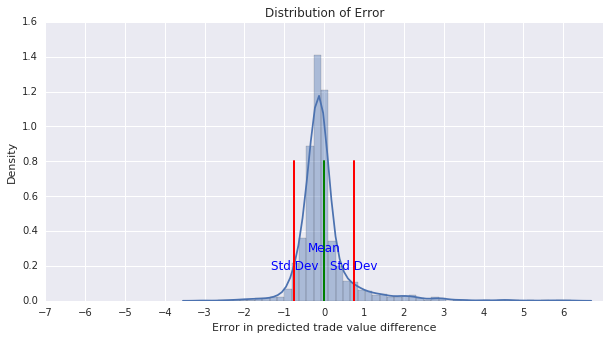


 Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Root mean square error: 0.7449919303929194
r2 score: 0.314537162267
Explained variance score 0.31457862923
Mean absolute error: 0.417440035456
Median absolute error: 0.240805054342


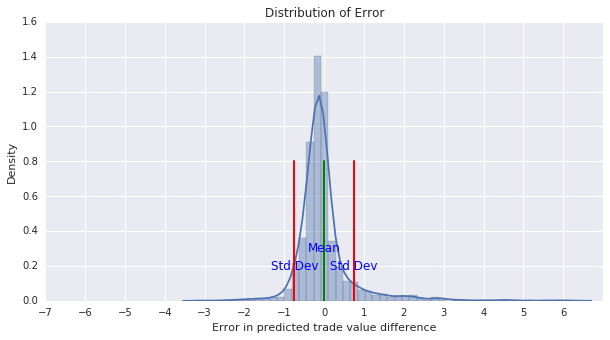


 Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Root mean square error: 0.8898939617016005
r2 score: 0.021958468092
Explained variance score 0.0224551039488
Mean absolute error: 0.555899537269
Median absolute error: 0.414234354555


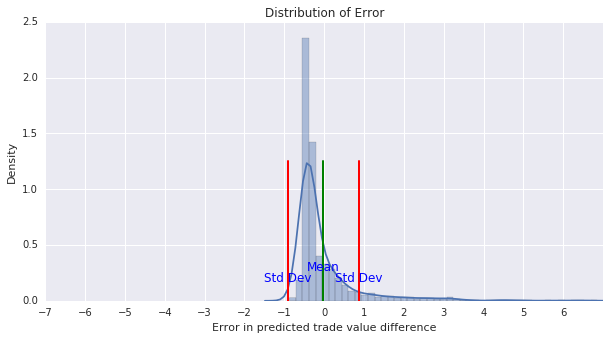


 DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
Root mean square error: 0.8445163699268878
r2 score: 0.119160215662
Explained variance score 0.119167885005
Mean absolute error: 0.423582118216
Median absolute error: 0.201064078895


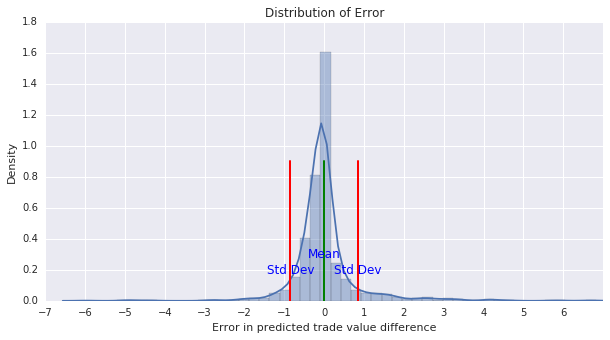


 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Root mean square error: 0.7622351924752121
r2 score: 0.282439093195
Explained variance score 0.282440507452
Mean absolute error: 0.402589489668
Median absolute error: 0.204725187338


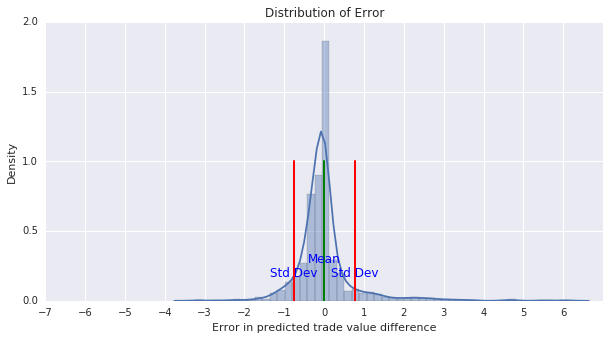


 KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=100, p=2,
          weights='uniform')
Root mean square error: 0.8707388914460263
r2 score: 0.0636102252875
Explained variance score 0.0642567812791
Mean absolute error: 0.501624921335
Median absolute error: 0.359917980503


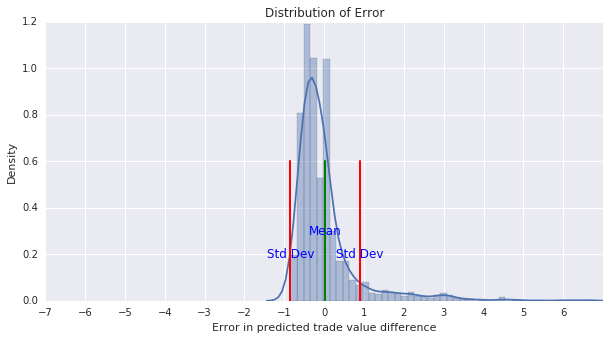

In [379]:
from sklearn.metrics import f1_score
clfFitList = []
for i in clfList:
    clf = i.fit(allRowsList[:3963],df_features_new['Abs_Trade_Value_Diff'][:3963] )
    clfFitList.append(clf)
    print("\n",i)
    predicted = clf.predict(allRowsList[3963:])
    calculate_error(df_features_new['Abs_Trade_Value_Diff'][3963:], predicted)

Root mean square error: 1.0248833775377233
r2 score: -0.0186773138316
Explained variance score -0.0169503631076
Mean absolute error: 0.599736115328
Median absolute error: 0.313411740813


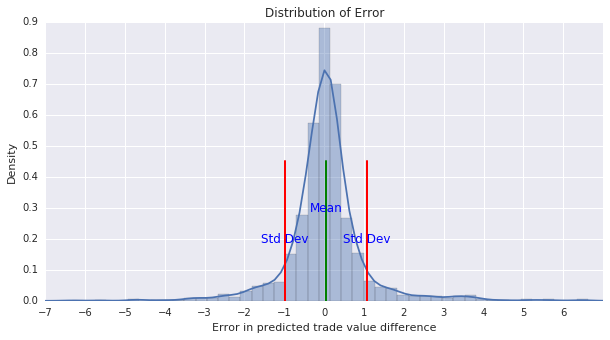

In [380]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
poly = PolynomialFeatures(degree=2)
X_ = poly.fit_transform(allRowsList[:3963])
predict_ = poly.fit_transform(allRowsList[3963:])

clf = linear_model.LinearRegression()
clf = clf.fit(X_, df_features_new['Trade_Value_Diff'][:3963])
clfFitList.append(clf)
pred = clf.predict(predict_)
calculate_error(df_features_new['Trade_Value_Diff'][3963:], pred)

Root mean square error: 0.9697999472000899
r2 score: 0.087879854483
Explained variance score 0.0887381839936
Mean absolute error: 0.475236398494
Median absolute error: 0.145109848286


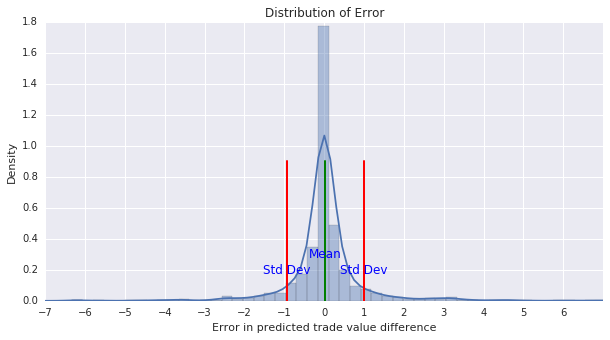

In [381]:
from  sklearn import ensemble
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(allRowsList[:3963], df_features_new['Trade_Value_Diff'][:3963])
clfFitList.append(clf)
pred = clf.predict(allRowsList[3963:])
calculate_error(df_features_new['Trade_Value_Diff'][3963:], pred)

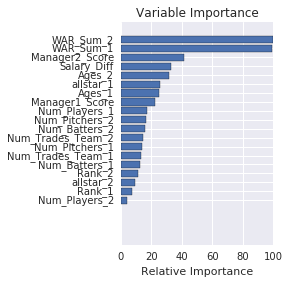

In [440]:
#Relative importance of features
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, inputV[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [385]:
#Final Prediction for 2015

df_pref_features = df_features[df_features['Year'] == 2015]
inputVPred = df_pref_features[["WAR_Sum_1", "WAR_Sum_2","Num_Players_1","Num_Players_2","Ages_1","Ages_2","Rank_1","Rank_2","Num_Trades_Team_1",
                                                            "Num_Trades_Team_2","Salary_Diff","allstar_1","allstar_2","Num_Pitchers_1",
                                                            "Num_Pitchers_2","Num_Batters_1","Num_Batters_2","Manager1_Score","Manager2_Score"]]

In [386]:
allRowsPredList = []
for idx,row in inputVPred.iterrows():
    currentRowList = row.values.tolist()
    allRowsPredList.append(currentRowList)

In [387]:
#Picking Random Forest as our final classifier
pred = clfFitList[4].predict(allRowsPredList)
df_pref_features['Predicted_Trade_Diff'] = pred
df_pref_features['Absolute_Predicted_Trade_Diff'] = abs(pred)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [436]:
df_pref_features = df_pref_features.sort(columns='Absolute_Predicted_Trade_Diff',ascending=False)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [437]:
pred_df = pd.DataFrame(columns = ['Rank','Date','Team1','Team2','Players Team1','Player Team2','Trade Value Diff'])
k = 0
for index,row in df_pref_features.iterrows():
    tranID = row['TranID']
    value = row['Predicted_Trade_Diff']
    tran = df_tran[df_tran['transaction-ID'] == tranID]
    teams = tran['from-team'].unique()
    t1 = teams[0]
    t2 = teams[1]
    p1List = []
    p2List = []
    for index,row in tran.iterrows():
        pl = df_master[df_master['retroID'] == row['player']]
        if row['from-team'] == t1:
            p1List.append(''.join(pl['nameFirst'].values +" "+ pl['nameLast'].values))
        else:
            p2List.append(''.join(pl['nameFirst'].values + " " + pl['nameLast'].values))
    p1str = ','.join(p1List)
    p2str = ','.join(p2List)
    date = tran['primary-date'].iloc[0]
    pred_df.loc[k] = [int(k+1),date,t1,t2,p1str,p2str,value]
    k += 1
    if(k==100):
        break

In [438]:
# Top 10 worst trades of 2015
pred_df.head(10)

,Rank,Date,Team1,Team2,Players Team1,Player Team2,Trade Value Diff
0,1.0,2015-11-12,ATL,ANA,"Andrelton Simmons,","Erick Aybar,,,",3.243647
1,2.0,2015-04-05,ATL,SDN,"Craig Kimbrel,Melvin Upton","Cameron Maybin,Carlos Quentin,Matt Wisler,,",2.239327
2,3.0,2015-05-27,LAN,ATL,"Juan Uribe,Chris Withrow","Alberto Callaspo,Eric Stults,Ian Thomas,Juan J...",1.387574
3,4.0,2015-11-11,MIN,NYA,Aaron Hicks,J. R. Murphy,1.372885
4,5.0,2015-01-10,TBA,OAK,"Ben Zobrist,Yunel Escobar","John Jaso,,,",1.333948
5,6.0,2015-07-30,MIA,ATL,"Mat Latos,Mike Morse,","Jose Peraza,Alex Wood,Bronson Arroyo,Jim Johns...",1.256636
6,7.0,2015-01-19,HOU,CHN,Dexter Fowler,"Luis Valbuena,Dan Straily",1.134766
7,8.0,2015-06-03,ARI,SEA,"Mark Trumbo,Vidal Nuno","Welington Castillo,Dominic Leone,,",1.028551
8,9.0,2015-07-31,PHI,TOR,Ben Revere,",",1.015970
9,10.0,2015-08-07,CLE,ATL,"Nick Swisher,Michael Bourn,",Chris Johnson,1.004355


In [325]:
pred_df.to_csv("Predicted_Ranks.csv")

Win/Lose Probability

In [349]:
df_features_x = df_features.sample(frac=1)

In [514]:
probInput = df_features[["WAR_Sum_1", "WAR_Sum_2","Num_Players_1","Num_Players_2","Ages_1","Ages_2"]]
probOutput = df_features['Trade_Value_Diff'].apply(lambda x : 1 if x > 0 else 0)

logTrainList = []
for idx,row in probInput.iterrows():
    currentRowList = row.values.tolist()
    logTrainList.append(currentRowList)
    
df_features_2015 = df_features[df_features['Year'] == 2015]
probInputPred = df_pref_features[["WAR_Sum_1", "WAR_Sum_2","Num_Players_1","Num_Players_2","Ages_1","Ages_2"]]
# Probability of winning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
clfLog = LogisticRegression()
model = clfLog.fit(logTrainList[:3963], probOutput[:3963])

# check the accuracy on the training set
model.score(logTrainList[3963:], probOutput[3963:])

0.64617239300783602

In [515]:
probPred  = model.predict_proba(probInputPred)

In [518]:
prob_df = pd.DataFrame(probPred,columns=['Team 1 Win Probability','Team 2 Win Probability'])

In [519]:
df_pref_features['Team 1 Win Probability'] = prob_df['Team 1 Win Probability'].values.tolist()
df_pref_features['Team 2 Win Probability'] = prob_df['Team 2 Win Probability'].values.tolist()

In [520]:
df_pref_features.head(10)

,TranID,Year,Team_1,Team_2,Trade_Value_Diff,WAR_Sum_1,WAR_Sum_2,Num_Players_1,Num_Players_2,Ages_1,Ages_2,Num_Player_Trades_1,Num_Player_Trades_2,Rank_1,Rank_2,Num_Trades_Team_1,Num_Trades_Team_2,Salary_Diff,allstar_1,allstar_2,Num_Pitchers_1,Num_Pitchers_2,Num_Batters_1,Num_Batters_2,Manager1_Score,Manager2_Score,Avg_Lops_1,Avg_Lops_2,Abs_Trade_Value_Diff,Num_Player_Diff,Age_Diff,WAR_Diff,Num_Trades_Diff,AllStar_Diff,Manager_Diff,Avg_Lopsided_Diff,Predicted_Trade_Diff,Absolute_Predicted_Trade_Diff,Team 1 Win Probability,Team 2 Win Probability
5612,77564,2015,ATL,ANA,1.968518,4.01,2.31,2,3,12.5,10.333333,0,0,4,3,14,10,5557138,0,1,0,0,1,1,0.513553,0.500000,0.096959,0.074647,1.968518,1,2.166667,1.70,0,-1,0.013553,0.022311,3.243647,3.243647,0.711487,0.288513
5532,75969,2015,ATL,SDN,0.123326,1.59,1.27,2,4,28.5,18.250000,0,4,4,4,14,7,16620897,4,2,1,1,1,2,0.513553,0.476505,0.096959,0.107875,0.123326,2,10.250000,0.32,4,2,0.037048,0.010917,2.239327,2.239327,0.500024,0.499976
5542,76291,2015,LAN,ATL,-0.256167,1.11,-0.54,2,4,30.0,30.500000,1,4,1,4,10,14,6567527,0,0,1,3,1,1,0.551298,0.513553,0.120953,0.049363,0.256167,2,0.500000,1.65,3,0,0.037745,0.071590,1.387574,1.387574,0.221265,0.778735
5609,77544,2015,MIN,NYA,0.146870,1.33,0.46,1,1,25.0,24.000000,0,0,2,2,4,6,524088,0,0,0,0,1,1,0.512346,0.557613,0.090172,-0.035859,0.146870,0,1.000000,0.87,0,0,0.045267,0.126031,1.372885,1.372885,0.599995,0.400005
5515,75068,2015,TBA,OAK,0.534529,3.07,0.93,2,3,33.0,10.333333,4,2,4,5,7,9,9421876,2,0,0,0,2,1,0.493827,0.506865,0.110577,-0.029821,0.534529,1,22.666667,2.14,2,2,0.013038,0.140398,1.333948,1.333948,0.515284,0.484716
5573,76685,2015,MIA,ATL,-0.268849,-0.42,-0.06,2,5,30.0,25.000000,6,2,3,4,4,14,2677530,0,2,1,4,1,1,0.443548,0.513553,0.440242,0.049363,0.268849,3,5.000000,0.36,4,-2,0.070005,0.390879,1.256636,1.256636,0.353720,0.646280
5520,75133,2015,HOU,CHN,0.944100,2.16,2.13,1,2,29.0,26.000000,1,2,2,3,8,9,5355061,0,0,0,1,1,1,0.467914,0.525120,-0.007139,-0.039775,0.944100,1,3.000000,0.03,1,0,0.057205,0.032636,1.134766,1.134766,0.555185,0.444815
5544,76334,2015,ARI,SEA,-0.292410,0.69,1.37,2,4,28.0,12.750000,2,0,3,4,8,14,0,1,0,1,1,1,1,0.487654,0.451175,0.155725,-0.085383,0.292410,2,15.250000,0.68,2,1,0.036479,0.241107,1.028551,1.028551,0.653893,0.346107
5586,76720,2015,PHI,TOR,0.000000,2.04,0.00,1,2,27.0,0.000000,1,0,5,1,5,8,4142594,0,0,0,0,1,0,0.463918,0.506387,-0.007721,0.293778,0.000000,1,27.000000,2.04,1,0,0.042469,0.301499,1.015970,1.015970,0.753697,0.246303
5594,76791,2015,CLE,ATL,0.555865,-0.77,-0.45,2,1,33.0,30.000000,4,2,3,4,4,14,28796083,3,0,0,0,2,1,0.529848,0.513553,-0.014906,0.049363,0.555865,1,3.000000,0.32,2,3,0.016295,0.064269,1.004355,1.004355,0.522811,0.477189


In [521]:
pred_df = pd.DataFrame(columns = ['Rank','Date','Team1','Team2','Players Team1','Player Team2','Trade Value Diff','Team 1 Win Probability','Team 2 Win Probability'])
k = 0
for index,row in df_pref_features.iterrows():
    tranID = row['TranID']
    value = row['Predicted_Trade_Diff']
    valTeam1 = row['Team 1 Win Probability']
    valTeam2 = row['Team 2 Win Probability']
    tran = df_tran[df_tran['transaction-ID'] == tranID]
    teams = tran['from-team'].unique()
    t1 = teams[0]
    t2 = teams[1]
    p1List = []
    p2List = []
    for index,row in tran.iterrows():
        pl = df_master[df_master['retroID'] == row['player']]
        if row['from-team'] == t1:
            p1List.append(''.join(pl['nameFirst'].values +" "+ pl['nameLast'].values))
        else:
            p2List.append(''.join(pl['nameFirst'].values + " " + pl['nameLast'].values))
    p1str = ','.join(p1List)
    p2str = ','.join(p2List)
    date = tran['primary-date'].iloc[0]
    pred_df.loc[k] = [int(k+1),date,t1,t2,p1str,p2str,value,valTeam1,valTeam2]
    k += 1
    if(k==100):
        break

In [522]:
pred_df

,Rank,Date,Team1,Team2,Players Team1,Player Team2,Trade Value Diff,Team 1 Win Probability,Team 2 Win Probability
0,1.0,2015-11-12,ATL,ANA,"Andrelton Simmons,","Erick Aybar,,,",3.243647,0.711487,0.288513
1,2.0,2015-04-05,ATL,SDN,"Craig Kimbrel,Melvin Upton","Cameron Maybin,Carlos Quentin,Matt Wisler,,",2.239327,0.500024,0.499976
2,3.0,2015-05-27,LAN,ATL,"Juan Uribe,Chris Withrow","Alberto Callaspo,Eric Stults,Ian Thomas,Juan J...",1.387574,0.221265,0.778735
3,4.0,2015-11-11,MIN,NYA,Aaron Hicks,J. R. Murphy,1.372885,0.599995,0.400005
4,5.0,2015-01-10,TBA,OAK,"Ben Zobrist,Yunel Escobar","John Jaso,,,",1.333948,0.515284,0.484716
5,6.0,2015-07-30,MIA,ATL,"Mat Latos,Mike Morse,","Jose Peraza,Alex Wood,Bronson Arroyo,Jim Johns...",1.256636,0.353720,0.646280
6,7.0,2015-01-19,HOU,CHN,Dexter Fowler,"Luis Valbuena,Dan Straily",1.134766,0.555185,0.444815
7,8.0,2015-06-03,ARI,SEA,"Mark Trumbo,Vidal Nuno","Welington Castillo,Dominic Leone,,",1.028551,0.653893,0.346107
8,9.0,2015-07-31,PHI,TOR,Ben Revere,",",1.015970,0.753697,0.246303
9,10.0,2015-08-07,CLE,ATL,"Nick Swisher,Michael Bourn,",Chris Johnson,1.004355,0.522811,0.477189
